# Current Calibration Routine #  
- SJ 7/17/22

This file will walk through capturing the zero offset count, and scalar for current measurement on each phase. 
- User will need to monitor current w/ osciliscope and input into script!

## Setup System & Connect via Ethernet ##

In [15]:
import os
import pathlib as pl
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt

repo_dir = pl.Path(os.path.dirname(os.getcwd()))
sys.path.append(str(repo_dir / 'AMDC-Firmware' / 'scripts'))

from AMDC import AMDC
from AMDC_Logger import AMDC_Logger, find_mapfile
from AMDC_LivePlot import AMDC_LivePlot

amdc = AMDC()

# After creating the amdc object...

# Set comm defaults for Ethernet
amdc.setup_comm_defaults('eth')

# Init ethernet 
amdc.eth_init()

# Set up the default ASCII command socket
s0, s0_id = amdc.eth_new_socket('ascii_cmd')
amdc.eth_set_default_ascii_cmd_socket(s0)

# Cretae AMDC Logger Object
mapfile_path = find_mapfile(repo_dir)
logger = AMDC_Logger(AMDC = amdc, mapfile = mapfile_path)

### Procedure ###
- get 20 seconds of mid rail no current for all sensors
    - do stats on columns of data to get mean value
    - store as zero count offset
- reprogram system with zero count offset
- repeat above 20 second mid rail to ensure mean ~0 counts
- on per phase basis run known current through sensor
    - repeat 20 seconds data aq.
    - stats on data to get mean count value
    - store mean count value
    - increase current 25A and run again 
        - 0, 15, 30, 45, 60, 75
        
Semikron power stack CT: HASS 100-S -> 100Arms sensor 0.00625V/A

LV ADC board: 0.00125 V/count

Target: ~0.00125/0.00625 A/count -> 0.2A/count


### Results ###
- Zero count offsets:
    - Iu: 1991
    - Iv: 1989
    - Iw: 2005
    - Idc: -32589

In [ ]:
0.00125/0.00625

## Zero Offset Calibration ##

In [13]:
# Setup Logger
logger.sync()

# Register Vars
logger.register('Iu Iv Iw Vdc Idc', samples_per_sec = 2000, var_type = 'double')

# Clear log
logger.empty_all()

# Define Command
# chn 0 phase U active high
# chn 1 phase V active high
# chn 2 phase W active high
# chn 3 All half rail
# chn 4 All ground
cmd_str = 'gen_ctrl chn 4'
amdc.cmd(cmd_str)

# Define Command
cmd_str = 'gen_ctrl init'
amdc.cmd(cmd_str)

# Record zero curr data for 20 seconds
logger.log(duration = 5)

# Define Command
cmd_str = 'gen_ctrl deinit'
amdc.cmd(cmd_str)

# Retrieve Data - return as Panda DataFrame obj
data = logger.dump(
     log_vars = 'Iu Iv Iw Idc', 
     file = 'calData\currentCal_All_0A.csv',
     comment = '')

# Unregister Vars
logger.unregister_all()
data.describe().to_csv('calData\zeroCountOffset_describe.csv')

	> log info
	> log reg 0 LOG_Iu 537542744 2000 double
['log reg 0 LOG_Iu 537542744 2000 double', 'SUCCESS']
	> log reg 1 LOG_Iv 537542752 2000 double
['log reg 1 LOG_Iv 537542752 2000 double', 'SUCCESS']
	> log reg 2 LOG_Iw 537542760 2000 double
['log reg 2 LOG_Iw 537542760 2000 double', 'SUCCESS']
	> log reg 3 LOG_Vdc 537542776 2000 double
['log reg 3 LOG_Vdc 537542776 2000 double', 'SUCCESS']
	> log reg 4 LOG_Idc 537542768 2000 double
['log reg 4 LOG_Idc 537542768 2000 double', 'SUCCESS']
	> log empty_all
['log empty_all', 'SUCCESS']
	> gen_ctrl chn 4
['gen_ctrl chn 4', 'SUCCESS']
	> gen_ctrl init
['gen_ctrl init', 'SUCCESS']
	> log start
['log start', 'SUCCESS']
	> log stop
['log stop', 'SUCCESS']
	> gen_ctrl deinit
['gen_ctrl deinit', 'SUCCESS']
	> log dump eth bin 0
Dumping: LOG_Iu
ERROR: timeout, could not find footer!
failed loading LOG_Iu... retrying

	> log dump eth bin 0
Dumping: LOG_Iu
ERROR: timeout, could not find footer!
failed loading LOG_Iu... retrying

	> log dump eth 

Exception: Loading Data Failed

In [5]:
data.Iu.describe()

count    40040.000000
mean        -0.161708
std          0.134048
min         -0.600000
25%         -0.200000
50%         -0.200000
75%          0.000000
max          0.400000
Name: Iu, dtype: float64

In [ ]:
data.Iv.describe()

In [ ]:
data.Iw.describe()

In [ ]:
data.Idc.describe()

## Probe & PSU Test ##

In [8]:
# Define Command
# chn 0 phase U active high
# chn 1 phase V active high
# chn 2 phase W active high
# chn 3 All half rail
# chn 4 All ground
cmd_str = 'gen_ctrl chn 0'
amdc.cmd(cmd_str)

# Define Command
cmd_str = 'gen_ctrl init'
amdc.cmd(cmd_str)


	> gen_ctrl chn 0
['gen_ctrl chn 0', 'SUCCESS']
	> gen_ctrl init
['gen_ctrl init', 'SUCCESS']


['gen_ctrl init', 'SUCCESS']

In [9]:
# Define Command
cmd_str = 'gen_ctrl deinit'
amdc.cmd(cmd_str)

	> gen_ctrl deinit
['gen_ctrl deinit', 'SUCCESS']


['gen_ctrl deinit', 'SUCCESS']

## Phase U Current Calibration ##

- Measured Current: Mean Count
    - 15.11 : -73.44
    - 30.23 : -149.25
    - 45.00 : -223.58
    - 60.30 : -299.48
    

In [29]:
# Setup Logger
logger.sync()

# Register Vars
logger.register('Iu Idc', samples_per_sec = 2000, var_type = 'double')

# Clear log
logger.empty_all()

# Define Command
# chn 0 phase U active high
# chn 1 phase V active high
# chn 2 phase W active high
# chn 3 All half rail
# chn 4 All ground
cmd_str = 'gen_ctrl chn 0'
amdc.cmd(cmd_str)

# Define Command
cmd_str = 'gen_ctrl init'
amdc.cmd(cmd_str)

# Let system settle
time.sleep(0.5)

# Record zero curr data for 5 seconds
logger.log(duration = 20)

# Define Command
cmd_str = 'gen_ctrl deinit'
amdc.cmd(cmd_str)

# Retrieve Data - return as Panda DataFrame obj
data = logger.dump(
     log_vars = 'Iu Idc', 
     file = 'calData\currentCal_PhU_XXA.csv',
     comment = '')

# Unregister Vars
logger.unregister_all()

data.describe().to_csv('calData\PhU_XXA_describe.csv')

	> log info
	> log reg 0 LOG_Iu 537542744 2000 double
['log reg 0 LOG_Iu 537542744 2000 double', 'SUCCESS']
	> log reg 1 LOG_Idc 537542768 2000 double
['log reg 1 LOG_Idc 537542768 2000 double', 'SUCCESS']
	> log empty_all
['log empty_all', 'SUCCESS']
	> gen_ctrl chn 0
['gen_ctrl chn 0', 'SUCCESS']
	> gen_ctrl init
['gen_ctrl init', 'SUCCESS']
	> log start
['log start', 'SUCCESS']
	> log stop
['log stop', 'SUCCESS']
	> gen_ctrl deinit
['gen_ctrl deinit', 'SUCCESS']
	> log dump eth bin 0
Dumping: LOG_Iu
Dump took: 3.805  sec
Dump rate: 10526.301  sps
Num samples: 40057 

	> log dump eth bin 1
Dumping: LOG_Idc
Dump took: 3.955  sec
Dump rate: 10129.155  sps
Num samples: 40057 

	> log unreg 0
['log unreg 0', 'SUCCESS']
	> log unreg 1
['log unreg 1', 'SUCCESS']


In [ ]:
data.Iu.describe()

## Idc Current Calibration ##

- Measured Current: Mean Count
    - 15.11 : 6970.27 
    - 30.23 : 14075.23 
    - 45.00 : 21059.67
    - 60.30 : 28183.78

In [ ]:
data.Idc.describe()

## Phase V Current Calibration ##

- Measured Current: Mean Count
    - 15.12 : -73.65
    - 30.25 : -149.55
    - 45.05 : -224.40
    - 60.32 : -300.68

In [ ]:
# Setup Logger
logger.sync()

# Register Vars
logger.register('Iv', samples_per_sec = 2000, var_type = 'double')

# Clear log
logger.empty_all()

# Define Command
# chn 0 phase U active high
# chn 1 phase V active high
# chn 2 phase W active high
# chn 3 All half rail
# chn 4 All ground
cmd_str = 'gen_ctrl chn 1'
amdc.cmd(cmd_str)

# Define Command
cmd_str = 'gen_ctrl init'
amdc.cmd(cmd_str)

# Let system settle
time.sleep(0.5)

# Record zero curr data for 5 seconds
logger.log(duration = 20)

# Define Command
cmd_str = 'gen_ctrl deinit'
amdc.cmd(cmd_str)

# Retrieve Data - return as Panda DataFrame obj
data = logger.dump(
     log_vars = 'Iv', 
     file = 'calData\currentCal_PhV_45A.csv',
     comment = '')

# Unregister Vars
logger.unregister_all()

data.describe().to_csv('calData\PhV_45A_describe.csv')

In [ ]:
data.Iv.describe()

## Phase W Current Calibration ##

- Measured Current: Mean Count
    - 15.15 : -74.21
    - 30.23 : -150.53
    - 45.05 : -225.51
    - 60.32 : -302.00

In [ ]:
# Setup Logger
logger.sync()

# Register Vars
logger.register('Iw', samples_per_sec = 2000, var_type = 'double')

# Clear log
logger.empty_all()

# Define Command
# chn 0 phase U active high
# chn 1 phase V active high
# chn 2 phase W active high
# chn 3 All half rail
# chn 4 All ground
cmd_str = 'gen_ctrl chn 2'
amdc.cmd(cmd_str)

# Define Command
cmd_str = 'gen_ctrl init'
amdc.cmd(cmd_str)

# Let system settle
time.sleep(0.5)

# Record zero curr data for 5 seconds
logger.log(duration = 20)

# Define Command
cmd_str = 'gen_ctrl deinit'
amdc.cmd(cmd_str)

# Retrieve Data - return as Panda DataFrame obj
data = logger.dump(
     log_vars = 'Iw', 
     file = 'calData\currentCal_PhW_45A.csv',
     comment = '')

# Unregister Vars
logger.unregister_all()

data.describe().to_csv('calData\PhW_45A_describe.csv')

In [ ]:
data.Iw.describe()

# View Results ###

In [ ]:
data[['Iu', 'Iv', 'Iw']].plot()

In [ ]:
data.Iu.plot()

In [ ]:
data[['Idc']].plot()

<AxesSubplot:xlabel='t'>

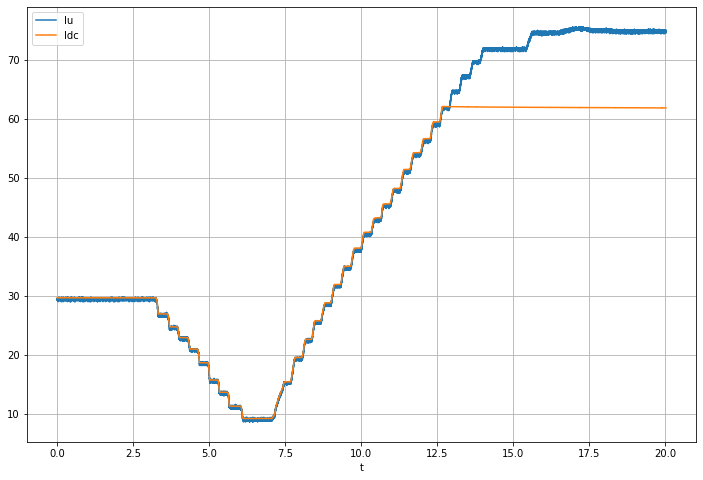

In [30]:
data[['Iu', 'Idc']].plot(figsize=(12,8), grid=True)

In [ ]:
data[['Iv']].plot()

In [ ]:
data.Iw.plot()

## PLOT EM ALL. V Loaded ##

In [ ]:
# Setup Logger
logger.sync()

# Register Vars
logger.register('Iu Iv Iw', samples_per_sec = 2000, var_type = 'double')

# Clear log
logger.empty_all()

# Define Command
# chn 0 phase U active high
# chn 1 phase V active high
# chn 2 phase W active high
# chn 3 All half rail
# chn 4 All ground
cmd_str = 'gen_ctrl chn 1'
amdc.cmd(cmd_str)

# Define Command
cmd_str = 'gen_ctrl init'
amdc.cmd(cmd_str)

# Let system settle
time.sleep(0.5)

# Record zero curr data for 5 seconds
logger.log(duration = 20)

# Define Command
cmd_str = 'gen_ctrl deinit'
amdc.cmd(cmd_str)

# Retrieve Data - return as Panda DataFrame obj
data = logger.dump(
     log_vars = 'Iu Iv Iw', 
     file = 'calData\currentCal_PhV_15A.csv',
     comment = '')

# Unregister Vars
logger.unregister_all()

data.describe().to_csv('calData\PhV_15A_describe.csv')

## Shutdown and Clear Logs

In [31]:
# Define Command
cmd_str = 'gen_ctrl deinit'
# Send command
amdc.cmd(cmd_str)

	> gen_ctrl deinit
['gen_ctrl deinit', 'FAILURE']


['gen_ctrl deinit', 'FAILURE']

In [14]:
# Unregister Vars
logger.unregister_all()

	> log unreg 0


Exception: ERROR: timeout, could not find command response!